In [40]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
from pyproj import CRS
from pyproj import Transformer
#from converter import wgs84_to_gcj02    #参见注意事项

### 4. Draw AQI (PM2.5) Image in Mercator 

### 4.1 Prepare x,y,z Data 

In [41]:
df_all = pd.read_csv(r'D:\Tommy\+WeatherData\china_aqi_map\aqi_all.csv')
print(df_all)

       s_id loc_name  city       lon       lat  value
0     1001A     万寿西宫    北京  116.3621  39.87840   47.0
1     1002A  定陵(对照点)    北京  116.2202  40.29150   12.0
2     1003A       东四    北京  116.4174  39.92890   65.0
3     1004A       天坛    北京  116.4072  39.88630   45.0
4     1005A      农展馆    北京  116.4620  39.93650   44.0
...     ...      ...   ...       ...       ...    ...
1697  3734A     理想之城    东营  118.3500  37.26000   51.0
1698  3860A   皇山花园小区    临沂  118.3920  35.03000   32.0
1699  3861A  寒亭区实验一小    潍坊  119.2041  36.76990   39.0
1700  3866A      三高中    营口  122.2469  40.66302   22.0
1701  3867A  平安区公安北苑  海东地区  102.0738  36.50560   39.0

[1702 rows x 6 columns]


### 4.2 Convert lat,lon to x,y(Mercator)

In [42]:
#WGS84 convert to web Mercator
from_crs_2 = CRS.from_epsg(4326)
to_crs_2 = CRS.from_epsg(3857)
transformer_2 = Transformer.from_crs(from_crs_2, to_crs_2, always_xy=True)

In [43]:
def get_x(r):
    x3,y3 = transformer_2.transform(r['lon'], r['lat'])
    return x3
def get_y(r):
    x3,y3 = transformer_2.transform(r['lon'], r['lat'])
    return y3
df_all['xx'] = df_all.apply(get_x, axis=1)
df_all['yy'] = df_all.apply(get_y, axis=1)

In [44]:
print(df_all)

       s_id loc_name  city       lon       lat  value            xx  \
0     1001A     万寿西宫    北京  116.3621  39.87840   47.0  1.295337e+07   
1     1002A  定陵(对照点)    北京  116.2202  40.29150   12.0  1.293757e+07   
2     1003A       东四    北京  116.4174  39.92890   65.0  1.295953e+07   
3     1004A       天坛    北京  116.4072  39.88630   45.0  1.295839e+07   
4     1005A      农展馆    北京  116.4620  39.93650   44.0  1.296449e+07   
...     ...      ...   ...       ...       ...    ...           ...   
1697  3734A     理想之城    东营  118.3500  37.26000   51.0  1.317466e+07   
1698  3860A   皇山花园小区    临沂  118.3920  35.03000   32.0  1.317934e+07   
1699  3861A  寒亭区实验一小    潍坊  119.2041  36.76990   39.0  1.326974e+07   
1700  3866A      三高中    营口  122.2469  40.66302   22.0  1.360846e+07   
1701  3867A  平安区公安北苑  海东地区  102.0738  36.50560   39.0  1.136280e+07   

                yy  
0     4.848287e+06  
1     4.908393e+06  
2     4.855616e+06  
3     4.849433e+06  
4     4.856719e+06  
...            ...  


In [47]:
print(df_all)

       s_id loc_name  city       lon       lat  value            xx  \
0     1001A     万寿西宫    北京  116.3621  39.87840   47.0  1.295337e+07   
1     1002A  定陵(对照点)    北京  116.2202  40.29150   12.0  1.293757e+07   
2     1003A       东四    北京  116.4174  39.92890   65.0  1.295953e+07   
3     1004A       天坛    北京  116.4072  39.88630   45.0  1.295839e+07   
4     1005A      农展馆    北京  116.4620  39.93650   44.0  1.296449e+07   
...     ...      ...   ...       ...       ...    ...           ...   
1697  3734A     理想之城    东营  118.3500  37.26000   51.0  1.317466e+07   
1698  3860A   皇山花园小区    临沂  118.3920  35.03000   32.0  1.317934e+07   
1699  3861A  寒亭区实验一小    潍坊  119.2041  36.76990   39.0  1.326974e+07   
1700  3866A      三高中    营口  122.2469  40.66302   22.0  1.360846e+07   
1701  3867A  平安区公安北苑  海东地区  102.0738  36.50560   39.0  1.136280e+07   

                yy  
0     4.848287e+06  
1     4.908393e+06  
2     4.855616e+06  
3     4.849433e+06  
4     4.856719e+06  
...            ...  


In [48]:
x = df_all['xx'].values
y = df_all['yy'].values
z = df_all['value'].values

In [49]:
print(x)
print(y)
print(z)

[12953369.71963598 12937573.48389241 12959525.68747685 ...
 13269739.71247046 13608462.65905624 11362803.43933445]
[4848287.40122816 4908393.12504335 4855615.5940864  ... 4407082.16188918
 4962763.53496164 4370416.03639781]
[47. 12. 65. ... 39. 22. 39.]


### 4.3 Generate the grid to interpolate

In [50]:
# size of the grid to interpolate
nx, ny = 650, 400 
lonmin = 71
lonmax = 136
latmin = 15
latmax = 55

#top left
x1,y1 = transformer_2.transform(lonmin, latmax)
#bottom right
x2,y2 = transformer_2.transform(lonmax, latmin)

xmin = x1
xmax = x2
ymin = y2
ymax = y1

print(xmin,xmax,ymin,ymax)
# generate two arrays of evenly space data between ends of previous arrays
xi = np.linspace(xmin, xmax, nx)
yi = np.linspace(ymin, ymax, ny)
print(xi)
print(yi)

7903683.846322423 15139450.747885207 1689200.1396078924 7361866.113051185
[ 7903683.84632242  7914832.94786566  7925982.0494089   7937131.15095214
  7948280.25249538  7959429.35403862  7970578.45558186  7981727.5571251
  7992876.65866834  8004025.76021158  8015174.86175482  8026323.96329806
  8037473.0648413   8048622.16638454  8059771.26792778  8070920.36947102
  8082069.47101426  8093218.5725575   8104367.67410074  8115516.77564398
  8126665.87718722  8137814.97873046  8148964.0802737   8160113.18181694
  8171262.28336018  8182411.38490342  8193560.48644666  8204709.5879899
  8215858.68953314  8227007.79107638  8238156.89261962  8249305.99416286
  8260455.0957061   8271604.19724934  8282753.29879258  8293902.40033582
  8305051.50187906  8316200.6034223   8327349.70496554  8338498.80650878
  8349647.90805202  8360797.00959526  8371946.1111385   8383095.21268174
  8394244.31422498  8405393.41576822  8416542.51731146  8427691.61885471
  8438840.72039795  8449989.82194118  8461138.923484

In [51]:
# generate grid 
xi, yi = np.meshgrid(xi, yi)

# colapse grid into 1D
xi, yi = xi.flatten(), yi.flatten()
print(xi)
print(yi)

[ 7903683.84632242  7914832.94786566  7925982.0494089  ...
 15117152.54479873 15128301.64634197 15139450.74788521]
[1689200.13960789 1689200.13960789 1689200.13960789 ... 7361866.11305119
 7361866.11305119 7361866.11305119]


### 4.4 Functions for simple IDW

In [52]:
from matplotlib.colors import LinearSegmentedColormap


In [53]:
def distance_matrix(x0, y0, x1, y1):
    """ Make a distance matrix between pairwise observations.
    Note: from <http://stackoverflow.com/questions/1871536> 
    """
    
    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T

    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])
    
    # calculate hypotenuse
    return np.hypot(d0, d1)

In [54]:
def simple_idw(x, y, z, xi, yi, power=1):
    """ Simple inverse distance weighted (IDW) interpolation 
    Weights are proportional to the inverse of the distance, so as the distance
    increases, the weights decrease rapidly.
    The rate at which the weights decrease is dependent on the value of power.
    As power increases, the weights for distant points decrease rapidly.
    """
    
    dist = distance_matrix(x,y, xi,yi)

    # In IDW, weights are 1 / distance
    weights = 1.0/(dist+1e-12)**power

    # Make weights sum to one
    weights /= weights.sum(axis=0)

    # Multiply the weights for each interpolated point by all observed Z-values
    return np.dot(weights.T, z)

base color is ligh blue

In [ ]:
# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
        (0,'#55dbf9'),
        (0.05, '#009966'),
        (0.1, '#ffde33'),
        (0.2, '#ff9933'),
        (0.3, '#cc0033'),
        (0.4, '#660099'),
        (1, '#7e0023')
    ], N=128)

base color is white

In [75]:
# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
        (0,'#ffffff'),
        (0.07, '#009966'),
        (0.1, '#ffde33'),
        (0.2, '#ff9933'),
        (0.3, '#cc0033'),
        (0.4, '#660099'),
        (1, '#7e0023')
    ], N=128)

In [56]:
def plot(x,y,z,grid):
    

    """ Plot the input points and the result """
    plt.figure(figsize=(15,10))
    plt.imshow(grid, extent=(xmin, xmax, ymax, ymin), cmap=white_viridis, interpolation='gaussian')
    #plt.scatter(x,y,c=z, cmap='rainbow', edgecolors='black')
    ax = plt.gca()
    ax.invert_yaxis()
    plt.colorbar()

### 4.5 Run the Interpolation

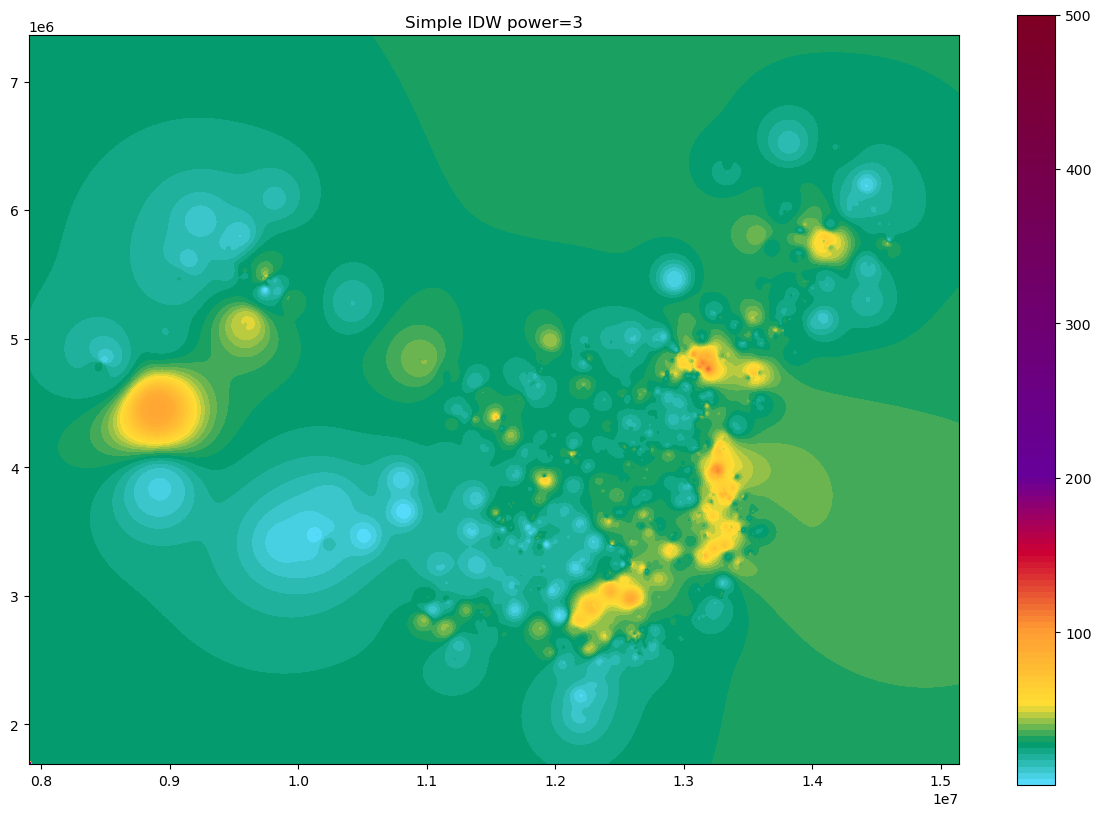

In [58]:
 # Calculate IDW
grid1 = simple_idw(x,y,z,xi,yi, power=3)
grid1 = grid1.reshape((ny, nx))
grid1[0][0]=500
plot(x,y,z,grid1)
plt.title('Simple IDW power=3')
#plt.show()
# Save the final image
plt.savefig(r'D:\Tommy\+WeatherData\china_aqi_map\aqiimage_mercator_with_borders.png', dpi=300, bbox_inches='tight')

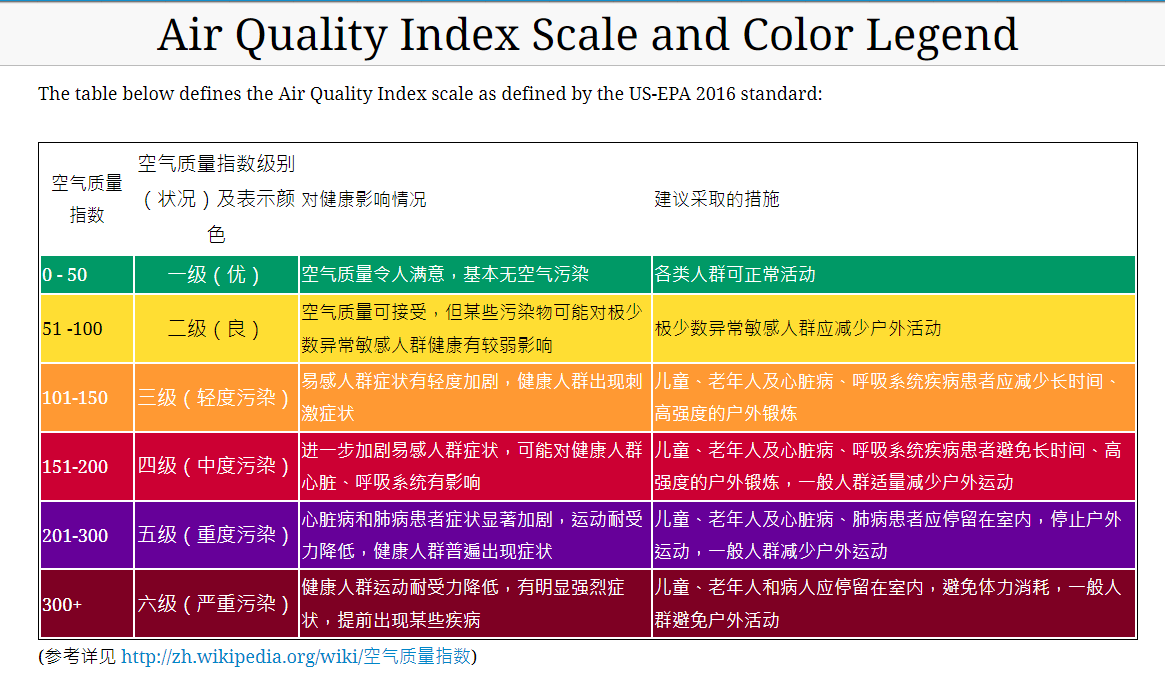

### 5.Map in mercator

### 5.1 Plot Mercator Map

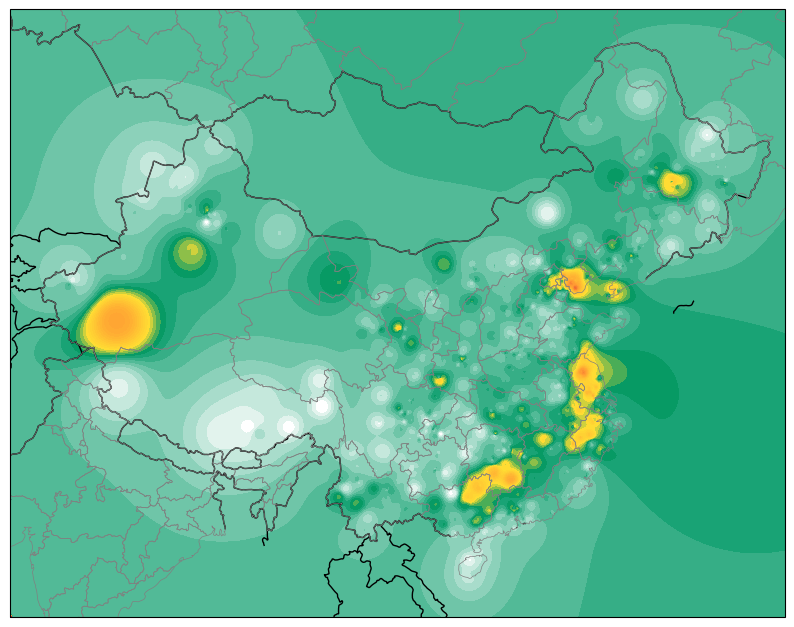

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the Google tile radar image
radar_tile = plt.imread(r'D:\Tommy\+WeatherData\accu_aqi_tiles\plumb\test\20230503-10-55-38.png')

# Define the map projection
proj = ccrs.Mercator()
#proj = ccrs.PlateCarree()
# Plot the radar tile image
fig = plt.figure(figsize=(10, 10.5))
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Plot the country borders

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
#cfeature.BORDERS
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1, edgecolor='black')
#ax.add_feature(cfeature.COASTLINE,linestyle='-', edgecolor='black', linewidth=1)
ax.add_feature(cfeature.STATES,linestyle='-', edgecolor='gray', linewidth=0.5)
#ax.add_feature(cfeature.STATES, linestyle='-', linewidth=1, edgecolor='gray')
ax.imshow(grid1, extent=(xmin, xmax, ymax, ymin), cmap=white_viridis, interpolation='gaussian')
# Plot the radar tile image on the map 
#extent is [xmin,xmax,ymin,ymax]
#ax.imshow(radar_tile, origin='upper', extent=[13775787, 14401959, 4383205, 5009377],transform=proj, alpha=0.5)
#tile 54,39
#ax.imshow(radar_tile, origin='upper', extent=[123.75, 129.374999, 36.597889,  40.979897],transform=proj, alpha=0.5)
#tile 55,38
#ax.imshow(radar_tile, origin='upper', extent=[129.374999, 134.999998, 31.952164,  36.597889],transform=proj, alpha=0.5)
# Set the x and y axis limits
ax.set_xlim(xmin,xmax) #[xmin,xmax]
ax.set_ylim( ymin,ymax) #[ymin, ymax]

# Save the final image
plt.savefig(r'D:\Tommy\+WeatherData\china_aqi_map\aqiimage_with_borders.png', dpi=300, bbox_inches='tight')

adding shapefile to map

In [64]:
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt

# Downloaded from http://biogeo.ucdavis.edu/data/gadm2/shp/DEU_adm.zip
fname = '/downloads/DEU/DEU_adm1.shp'

adm1_shapes = list(shpreader.Reader(fname).geometries())

ax = plt.axes(projection=ccrs.PlateCarree())

plt.title('Deutschland')
ax.coastlines(resolution='10m')

ax.add_geometries(adm1_shapes, ccrs.PlateCarree(),
                  edgecolor='black', facecolor='gray', alpha=0.5)

ax.set_extent([4, 16, 47, 56], ccrs.PlateCarree())

plt.show()

DriverError: '/downloads/DEU/DEU_adm1.shp' does not exist in the file system, and is not recognized as a supported dataset name.

In [ ]:
import matplotlib.pyplot as plt
import cartopy
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs

ax = plt.axes(projection=ccrs.PlateCarree())
#ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
#ax.add_feature(cartopy.feature.COASTLINE)
#ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)
#ax.add_feature(cartopy.feature.LAKES, alpha=0.95)
#ax.add_feature(cartopy.feature.RIVERS)
ax.set_extent([-150, 60, -25, 60])

shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()

for country in countries:
    if country.attributes['adm0_a3'] == 'USA':
        ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          facecolor=(0, 0, 1),
                          label=country.attributes['adm0_a3'])
    else:
        ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          facecolor=(0, 1, 0),
                          label=country.attributes['adm0_a3'])

plt.show()